<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/Practica5.2.%20CNN%20con%20datasets%20peque%C3%B1os.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 5.2. Redes Convolucionales con pocos datos

In [1]:
from tensorflow import keras
keras.__version__

'2.4.0'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

Es común oir que Deep Learning solo es válido cuando tenemos una cantidad inmensa de datos, y aunque es una afirmación que es válida parcialmente (ya que extrae características interesantes de los datos sin necesidad de acudir a ingeniería manual), podemos encontrar situaciones en las que con unos cientos de datos es suficiente para extraer un modelo (pequeño) interesante si el problema presenta suficiente regularidad.

## 1. Entrenando una CNN con pocos datos

Tener que entrenar un modelo de clasificación sobre pocos datos es una situación muy común. Aunque, por supuesto, qué consideramos pocos datos es algo que depende del problema y del contexto, y puede ir desde unos cuantos cientos hasta decenas de miles cuando el problema es más complicado.

Para hacer las pruebas de este caso vamos a construir un pequeño  clasificador de imágenes para distinguir entre "perros" y "gatos". El dataset que usaremos está extraído de una competición de Kaggle en el que los datos los proporciona [Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765). Para reproducir esta práctica, primero debes descargar el dataset completo pinchando en el enlace anterior, y luego pinchar en Download. Después, descomprímelo al lado de este fichero notebook, dentro de una carpeta con nombre `kagglecatsanddogs_3367a`. Alternativamente, si estás en Google Colab, puedes descargar y descomprimir el dataset con las siguientes líneas. Es posible que el enlace siguiente deje de funcionar en algún momento, si es así, descarga manualmente el dataset y súbelo a la sesión.

In [3]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

--2020-12-07 16:39:53--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 92.123.124.137, 2a02:26f0:e600:291::e59, 2a02:26f0:e600:2a6::e59
Connecting to download.microsoft.com (download.microsoft.com)|92.123.124.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   138MB/s    in 5.8s    

2020-12-07 16:39:58 (137 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [ ]:
!unzip kagglecatsanddogs_3367a.zip -d kagglecatsanddogs_3367a 

Nosotros usaremos solo una sección del dataset que ellos proporcionan, con un total de 4.000 imágenes (2.000 de cada tipo), y donde dividiremos en 2.000 / 1.000 / 1.000 de entrenamiento / validación / test, respectivamente, completamente balanceados.

Vamos a comenzar con una versión muy sencilla de una red convolucional que entrenaremos con las 2.000 imágenes que tenemos en el conjunto de entrenamiento, sin hacer ningún tipo de regularización, solo con el fin de obtener un modelo base sobre el que medir posteriormente las mejoras que introduzcamos. Con esta primera versión, sin ningún tipo de mejora adicional, somos capaces de alcanzar ~70% de accuracy. Veremos que en este momento nuestro principal problema es el de sobreajuste, debido principalmente a la ausencia de suficientes datos para entrenar, por lo que tendremos que introducir alguna técnica que nos permita aliviar este problema. 

Como indicamos en el tema de Regularización, debido a que estamos en un problema de imágenes, es común hacer uso de la técnica de **Data Augmentation**, que junto con una capa de dropout permitirá alcanzar un rendimiento que rondará el 82% (una mejora del 12% absoluto).

## 2. El Dataset

En la carpeta `CatsDogs` puedes encontrar el conjunto inicial de 4,000 imágenes al que hacíamos alusión anteriormente. Dentro de esa carpeta ya están separadas las imágenes en los diversos conjuntos de entrenamiento, validación y test que usaremos, así como las carpetas `Cats` y `Dogs` con las imágenes originales..

El código que permite construir los datasets a partir del original se muestra a continuación, pero solo a título informativo, porque para el curso ya se proporcionan construidos (así que no lo ejecutes para no repetir el trabajo ya realizado):

In [5]:
import os, shutil
os.getcwd()

'/content'

El siguiente código construye un dataset subconjunto del dataset original de cats and dogs. Ejecutarlo solo cuando solo se disponga de los datos originales por primera vez.

In [6]:
# Ruta al directorio del dataset original descomprimido
original_dataset_dir = 'kagglecatsanddogs_3367a'

# El directorio donde vamos a guardar el dataset más pequeño
base_dir = 'cat_dogs'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directorios para nuestras particiones de
# entrenamiento, validación y test
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directorio con nuestras imágenes de gatos (cats) para entrenamiento
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directorio con nuestras imágenes de perros (dogs) para entrenamiento
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directorio con nuestras imágenes de gatos para validación
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directorio con nuestras imágenes de perros para validación
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directorio con nuestras imágenes de gatos para test
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directorio con nuestras imágenes de dogs para test
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

original_dataset_dir = os.path.join(original_dataset_dir, 'PetImages')
original_cat_dataset_dir = os.path.join(original_dataset_dir, 'Cat')

# Copiar las primeras 1000 imágenes de gatos a train_cats_dir
fnames = ['{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_cat_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copiar las siguientes 500 imágenes de gatos a validation_cats_dir
fnames = ['{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_cat_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copiar las siguientes 500 imágenes de gatos a test_cats_dir
fnames = ['{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_cat_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
original_dog_dataset_dir = os.path.join(original_dataset_dir, 'Dog')

# Copiar las siguientes 500 imágenes de perros a train_dogs_dir
fnames = ['{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dog_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copiar las siguientes 500 imágenes de perros a validation_dogs_dir
fnames = ['{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dog_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copiar las siguientes 500 imágenes de perros a test_dogs_dir
fnames = ['{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dog_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Usa el siguiente código para comprobar si alguna imagen está corrupta:

In [7]:
# de https://stackoverflow.com/questions/63754311/unidentifiedimageerror-cannot-identify-image-file
import os
from PIL import Image
folder_path = train_dir
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

UnidentifiedImageError: ignored

Si el código anterior falla en alguna imagen, bórrala y copia otra de la misma categoría en su lugar. Recuerda, sigue por el 2000, ya que por ahí dejamos de copiar:

In [8]:
!rm cat_dogs/train/cats/666.jpg
!cp kagglecatsanddogs_3367a/PetImages/Cat/2001.jpg cat_dogs/train/cats

Puedes comprobar que los números que indicábamos son los correctos:


In [10]:
print('Número imágenes entrenamiento Gatos:', len(os.listdir(train_cats_dir)))

Número imágenes entrenamiento Gatos: 1000


In [9]:
print('Número imágenes entrenamiento Perros:', len(os.listdir(train_dogs_dir)))

Número imágenes entrenamiento Perros: 1000


In [11]:
print('Número imágenes validación Gatos:', len(os.listdir(validation_cats_dir)))

Número imágenes validación Gatos: 500


In [12]:
print('Número imágenes validación Perros:', len(os.listdir(validation_dogs_dir)))

Número imágenes validación Perros: 500


In [13]:
print('Número imágenes test Gatos:', len(os.listdir(test_cats_dir)))

Número imágenes test Gatos: 500


In [15]:
print('Número imágenes test Perros:', len(os.listdir(test_dogs_dir)))

Número imágenes test Perros: 500



Como el conjunto está completamente balanceado, la precisión de clasificación (binaria, en este caso) es una buena medida del rendimiento del modelo.


## 3. Construyendo el modelo

Vamos a reutilizar la estructura de Red Convolucional que vimos en el ejemplo anterior (MNIST), que constaba de: una pila alternada de capas `layer_conv_2d()` (con activación `relu`) y capas `layer_max_pooling_2d()`.

Como las imágenes de este problema son más grandes y el problema es más complejo, haremos la red más grande con una capa más de cada tipo, por lo que aumentaremos la capacidad de la red y a la vez reduciremos el tamaño de salida de la última capa, que habrá que aplanar de forma similar con `layer_flatten()`. Como comenzamos con imágenes de tamaño 150x150 (es arbitrario), acabaremos con un mapa de características de 7x7 justo como entrada a la capa `layer_flatten()`.

A medida que la profundidad del mapa de características aumente (de 32 a 128), el tamaño del mismo disminuye (de 148x148 a 7x7), un patrón que es habitual en la mayoría de redes CNN.

Como el problema es de clasificación binaria, acabamos la red con una capa `layer_dense()` de una sola unidad y con activación `sigmoid`, que codificará la probabilidad de que la red esté mirando un elemento de cada una de las clases.


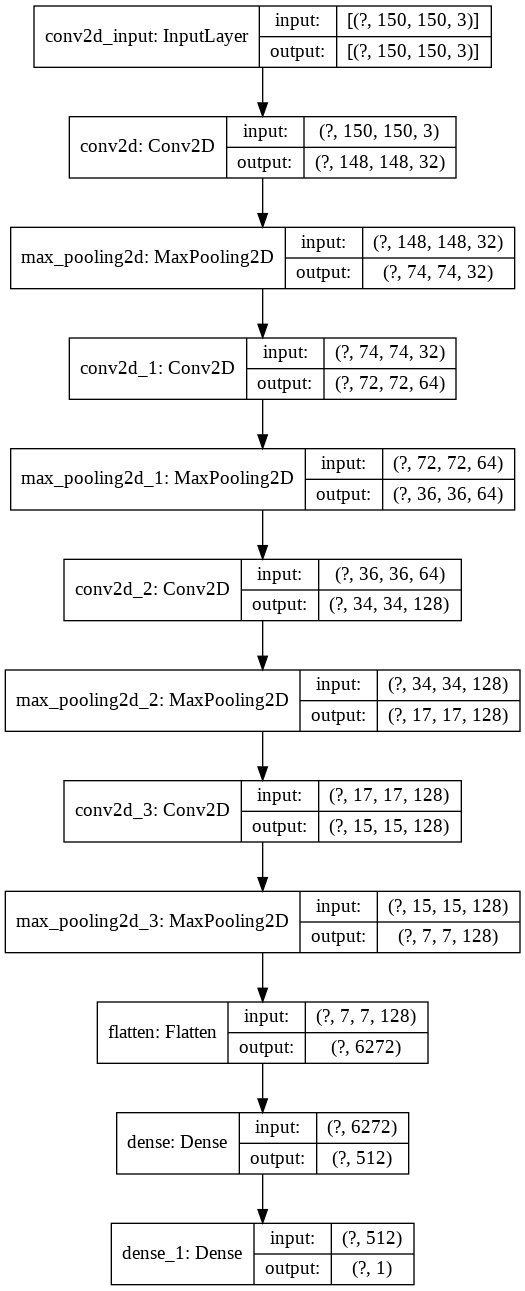

In [16]:
from keras import layers
from keras import models
from keras.utils.vis_utils import plot_model

CNN = models.Sequential()
CNN.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(512, activation='relu'))
CNN.add(layers.Dense(1, activation='sigmoid'))

plot_model(CNN, to_file='CNNCatsDogs_plot.png', show_shapes=True, show_layer_names=True)

Mira la arquitectura construida:
<!--![](imgs/CNNCatsDogs_plot.png)-->

In [17]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Para el paso de compilación haremos uso de las propiedades habituales:


In [18]:
from keras import optimizers

CNN.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## 4. Preprocesamiento de los datos

Como ya sabemos, los datos deben ser formateados para ser convertidos en tensores de punto flotante para alimentar la red, pero lo que tenemos son ficheros JPEG, así que los pasos para convertirlos son:

* Leer los ficheros de imágenes.
* Decodificar JPEG en una matriz de RGB.
* Convertir la matriz en tensores de punto flotante.
* Re-escalar los valores de `[0,255]` a `[0, 1]`.

Aunque puede parece algo tedioso, Keras proporciona utilidades para llevar a cabo este tipo de acciones, que son muy comunes. En particular, incluye la función `image_data_generator()`, que automáticamente convierte ficheros de imágenes en tensores preprocesados:

**NOTA: Las funciones anteriores necesitan la librería `Pillow` de Python.**

In [19]:
from keras.preprocessing.image import ImageDataGenerator

# Todas las imágenes serán re-escaladas por 1,0/255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Este es el directorio destino
        train_dir,
        # Todas las imágenes serán redimensionadas a 150x150
        target_size=(150, 150),
        batch_size=20,
        # Puesto que usamos la pérdida binary_crossentropy, necesitamos etiquetas binarias
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Este proceso ha generado un paquete (batch) de imágenes de tamaño `(20, 150, 150, 3)` (20 imágenes de 150x150 con 3 canales) y un paquete (batch) de etiquetas de tamaño `(20)`).


In [20]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Se debe tener en cuenta que el generador crea los batches de imágenes indefinidamente, haciendo un loop sobre el conjunto de imágenes de la carpeta circularmente (o aleatoriamente). En realidad, estas imágenes no se procesan previamente, sino que se crea un batch cuando el entrenamiento lo requiere. Esta característica hará que el proceso de entrenamiento tenga ligeras diferencias a las vistas anteriormente. 

Durante el entrenamiento debemos usar el generador anterior, y para eso Keras amplía la función `fit` para que acepte generadores (anteriormente había otra función llamada `fit_generator`), de tal forma que acepta como primer argumento un generador que producirá batches de entradas y etiquetas de forma indefinida, al estilo del que hemos escrito antes. 

Como los datos se generan sin fin, el generador necesita saber cuántos batches tomar para cada epoch, para lo que hace uso del argumento `steps_per_epoch`: tras haber tomado `steps_per_epoch` batches del generador (es decir, tras haber ejecutado `steps_per_epoch` pasos del optimizador) el proceso de entrenamiento pasará a la siguiente epoch. Eso sí, para no repetir imágenes en una misma época, hay una restricción y es que no se pueden recorrer más imágenes de las que hay en la carpeta de train (o validation) en una misma época. Por tanto, se suele asignar: `steps_per_epoch = num_samples / batch_size`.

Cuando se usa `fit`, se puede pasar un argumento `validation_data` tal. Este argumento puede ser un generador o una lista de arrays. Si pasas un generador, funcionará indefinidamente, por lo que tendrás que especificar también el argumento `validation_steps`, que indica cuántos batches crear para la evaluación.

In [21]:
entrenamiento = CNN.fit(
      train_generator,
      steps_per_epoch=100,   # tomará 100 batches, de 20 imágenes cada uno: total 2000
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)   # tomará 50 batches, de 20 imágenes cada uno: total 1000

Epoch 1/30
100/100 [==============================] - 12s 117ms/step - loss: 0.6910 - acc: 0.5410 - val_loss: 0.6855 - val_acc: 0.5050
Epoch 2/30
100/100 [==============================] - 12s 117ms/step - loss: 0.6504 - acc: 0.6185 - val_loss: 0.6284 - val_acc: 0.6460
Epoch 3/30
100/100 [==============================] - 12s 115ms/step - loss: 0.6031 - acc: 0.6625 - val_loss: 0.5967 - val_acc: 0.6690
Epoch 4/30
100/100 [==============================] - 12s 116ms/step - loss: 0.5591 - acc: 0.7215 - val_loss: 0.5914 - val_acc: 0.6710
Epoch 5/30
100/100 [==============================] - 12s 118ms/step - loss: 0.5367 - acc: 0.7300 - val_loss: 0.5691 - val_acc: 0.7070
Epoch 6/30
100/100 [==============================] - 12s 116ms/step - loss: 0.5053 - acc: 0.7520 - val_loss: 0.5690 - val_acc: 0.6940
Epoch 7/30
100/100 [==============================] - 12s 116ms/step - loss: 0.4844 - acc: 0.7565 - val_loss: 0.5593 - val_acc: 0.7080
Epoch 8/30
100/100 [==============================] - 1

Es una buena práctica grabar el modelo tras el entrenamiento, sobre todo si puede consumir un tiempo excesivo:


In [22]:
CNN.save('cats_and_dogs_1.h5')

Representemos la pérdida y precisión experimentada en el proceso de entrenamiento para poder analizar cómo se comporta el modelo:


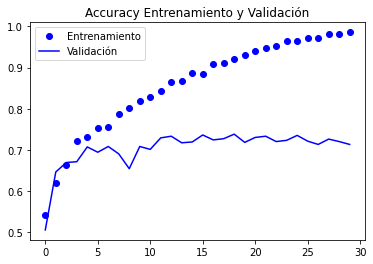

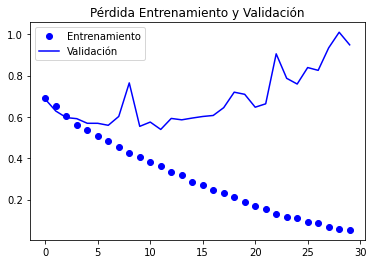

In [23]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = entrenamiento.history['acc']
val_acc = entrenamiento.history['val_acc']
ent_loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida Entrenamiento y Validación')
plt.legend()

plt.show()

Según vimos en el tema anterior, estas curvas son características de un aprendizaje con sobreajuste: la precisión de entrenamiento se incrementa linealmente con el tiempo, hasta alcanzar valores cercanos al 100%, mientras que la de validación se estanca en el 70-75%. La pérdida de validación alcanza el mínimo tras unas 5 epochs, mientras que la de entrenamiento continúa cayendo hasta que prácticamente alcanza el valor 0.

Como tenemos relativamente pocos ejemplos de entrenamiento, el sobreajuste se convierte en nuestro principal problema. Ya hemos visto algunas técnicas para mitigar este efecto, como son dropout y regularization, pero en esta ocasión comprobaremos cómo funciona **Data Augmentation**, que suele dar buenos resultados al trabajar con imágenes.

## 5. Usando Data Augmentation

Con una cantidad inifinita de datos, mostrando todas las posibles opciones existentes, el modelo nunca se sobreajustaría. _Data augmentation_ intenta simuar esta situación ideal generando más datos de entrenamiento a partir de los ejemplos disponibles por medio de la aplicación de transformaciones aleatorias que generan imágenes similares. El objetivo es hacer que nuestro modelo no vea dos veces la misma imagen exacta, lo que ayuda a que el modelo generalice mejor.

En Keras esto se puede hacer configurando un conjunto de transformaciones aleatorias para que sean ejecutadas sobre las imágenes que lee el generador `image_data_generator()`. Veamos un ejemplo que añade más opciones a las ya vistas:

In [24]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Éstas solo son algunas de las opciones disponibles (en la documentación de Keras puedes encontrar más). Veamos cómo funcionan sobre alguna imagen concreta de nuestro dataset:

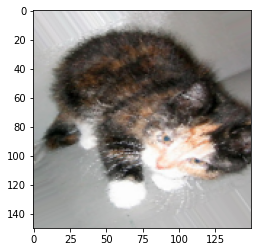

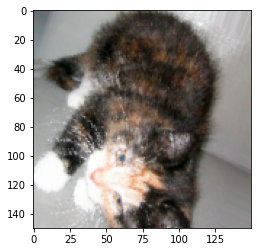

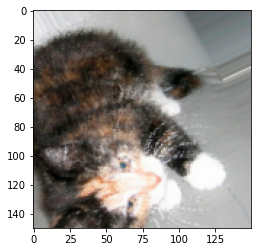

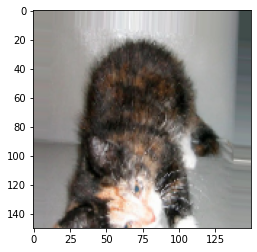

In [25]:
# Este es el módulo con las utilidades de preprocesamiento de imágenes
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# Escogemos una imagen parao "aumentar" (augment)
img_path = fnames[3]

# Lee la imagen y la redimensiona
img = image.load_img(img_path, target_size=(150, 150))

# La convierte a un Numpy array con shape (150, 150, 3)
x = image.img_to_array(img)

# Se redimensiona a (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# El método .flow() abajo genera batches de imágenes transformadas aleatoriamente.
# Iterará indefinidamente, por lo que necesitamos "romper" (`break`) el bucle en algún momento.
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

Si entrenamos una red usando esta nueva configuración con datos aumentados, ésta no verá dos veces la misma entrada, aunque evidentemente las entradas estarán altamente correlacionadas porque provienen de unas cuantas imágenes originales. Como consecuencia, no tiene porqué ser suficiente para eliminar el sobreajuste, y por esa razón intercalaremos también una capa intermedia de dropout justo antes de la capa clasificadora densa:

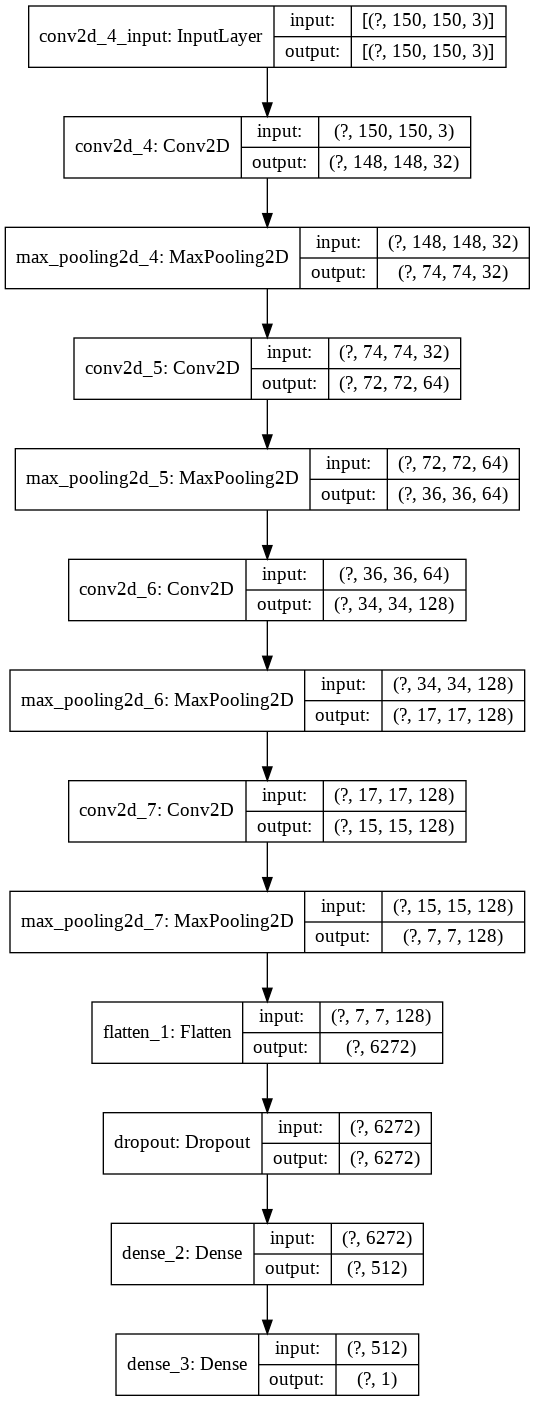

In [26]:
CNN_DA = models.Sequential()
CNN_DA.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
CNN_DA.add(layers.MaxPooling2D((2, 2)))
CNN_DA.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_DA.add(layers.MaxPooling2D((2, 2)))
CNN_DA.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_DA.add(layers.MaxPooling2D((2, 2)))
CNN_DA.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_DA.add(layers.MaxPooling2D((2, 2)))
CNN_DA.add(layers.Flatten())
CNN_DA.add(layers.Dropout(0.5))
CNN_DA.add(layers.Dense(512, activation='relu'))
CNN_DA.add(layers.Dense(1, activation='sigmoid'))

CNN_DA.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

plot_model(CNN_DA, to_file='CNNCatsDogsDA_plot.png', show_shapes=True, show_layer_names=True)

<!--![](imgs/CNNCatsDogsDA_plot.png)-->
Vamos a entrenar ahora la red usando estas dos características nuevas:


In [32]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Observa que los datos de validación no deben ser aumentados!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Este es el directorio de destino
        train_dir,
        # Todas las imágenes son redimensionadas a 150x150
        target_size=(150, 150),
        batch_size=16, # reducimos el batch size a 16, para no sobrepasar la restricción y que sea potencia de 2
        # Dado que usamos la pérdida binary_crossentropy, necesitamos etiquetas binarias
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

entrenamiento_DA = CNN_DA.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 18s 176ms/step - loss: 0.4905 - acc: 0.7750 - val_loss: 0.4912 - val_acc: 0.7462
Epoch 2/100
100/100 [==============================] - 18s 176ms/step - loss: 0.4789 - acc: 0.7706 - val_loss: 0.4776 - val_acc: 0.7588
Epoch 3/100
100/100 [==============================] - 18s 177ms/step - loss: 0.4660 - acc: 0.7669 - val_loss: 0.5876 - val_acc: 0.7250
Epoch 4/100
100/100 [==============================] - 18s 178ms/step - loss: 0.4595 - acc: 0.7744 - val_loss: 0.4663 - val_acc: 0.7763
Epoch 5/100
100/100 [==============================] - 18s 177ms/step - loss: 0.4853 - acc: 0.7638 - val_loss: 0.4673 - val_acc: 0.7713
Epoch 6/100
100/100 [==============================] - 18s 177ms/step - loss: 0.4856 - acc: 0.7556 - val_loss: 0.4572 - val_acc: 0.7750
Epoch 7/100
100/100 [==============================] - 18s 177ms/step - loss: 0.4825 - acc: 0.7650 -

Grabemos nuestro modelo, que usaremos un poco más adelante, y así no tenemos que volver a entrenarlo (en este caso, al haber sido 100 epochs, el tiempo que tarda ya empiezan a ser alto). Si estás en Google Colab, recuerda descargar el fichero generado o copiarlo a Google Drive.


In [33]:
CNN_DA.save('cats_and_dogs_DA.h5')

Y representemos los resultados para compararlos con el modelo básico anterior:


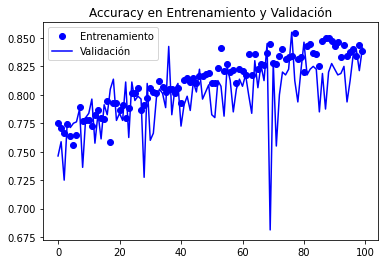

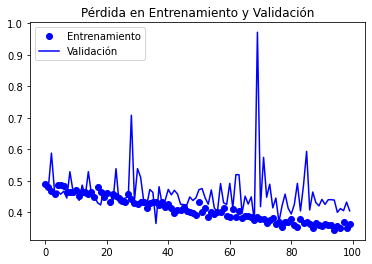

In [34]:
ent_acc = entrenamiento_DA.history['acc']
val_acc = entrenamiento_DA.history['val_acc']
ent_loss = entrenamiento_DA.history['loss']
val_loss = entrenamiento_DA.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

Según la información que dan estas gráficas, gracias a la combinación de data augmentation y dropout ya no tenemos sobreajuste. Ambas curvas se mantienen cerca, y ahora alcanzamos una precisión del 82%, lo que supone una mejora considerable respecto del modelo no regularizado.

Ajustando las técnicas de regularización y afinando los parámetros de la red (el número de filtros por capa y el número de capas), podriamos subir quizás hasta un 86-87% de precisión, pero será muy difícil superar este punto entrenando nuestro modelo con tan pocos datos desde cero. Hemos de buscar soluciones alternativas...

## 6. Guardado del dataset

En la próxima práctica vamos a volver a utilizar el dataset que hemos creado. Para no tener que repetir el proceso, es mejor que lo guardes. Si estás en local, solo tienes que evitar borrar la carpeta `cat_dogs`. Si estás en Google Colab, una opción es copiar la carpeta a tu Google Drive (necesitarás unos 200MB). Para ello, vamos a emplear el siguiente código. Esto también te puede valer para el sentido inverso, por si quieres subir datasets a través de tu Google Drive. 

* Paso 1: comprime la carpeta en un fichero zip. Si no quieres guardarlo en tu Google Drive, puedes descargarlo en tu equipo. Después tendrás que subirlo otra vez. Para ello, comprime la carpeta en zip, y después, en el navegador de archivos de la izquierda, selecciona el fichero y descárgalo. Si quieres guardarlo en tu Google Drive, sigue adelante.

In [ ]:
!zip -r cat_dogs.zip cat_dogs

* Paso 2: monta tu google drive. Ejecuta la siguiente celda y sigue las instrucciones (pincha en el enlace generado, elege tu cuenta de Google, y copia y pega el código generado):

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Paso 3: copia la carpeta. Puedes usar el mismo comando `cp`.

In [30]:
!cp cat_dogs.zip /content/drive/MyDrive

* Paso 4: aplica los cambios y desmonta tu google drive.

In [31]:
drive.flush_and_unmount()

## 7. Ejercicio Opcional Propuesto

Prueba a realizar el mismo procedimiento sobre el dataset [CIFAR10](https://keras.io/api/datasets/cifar10/), que está disponible desde Keras.

A continuación se disponen los nombres de las etiquetas:

In [ ]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']